In [4]:
import re
import jovian
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
from collections import Counter

## Data Preprocessing

* Regex cheatsheet
    * https://www.rexegg.com/regex-quickstart.html
* Regex test - live
    * https://regexr.com/
* Datetime format
    * http://strftime.org/

In [7]:
def rawToDf(file):
    with open(file, 'r',encoding='utf8') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split('\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s', raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall('\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s', raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
   
    # converting date-time pattern which is of type String to type datetime, format is to be specified for the whole string where the placeholders are extracted by the method    
    try:
        df['date_time'] = df['date_time'].apply(lambda x: dateparser.parse(x))
    except:
        print("oo")
        try:
            df['date_time'] = pd.to_datetime(df['date_time'], format='%m/%d/%y, %H:%M - ') #10/20/19, 10:24 pm - 
        except:
            df['date_time'] = pd.to_datetime(df['date_time'], format='%d/%m/%Y, %H:%M - ') #20/10/2019, 10:24 pm -
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("grp_notif")
            msgs.append(a[0])

    # creating new columns         

    df['user'] = usernames
    df['msg'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

### Import data

In [8]:
df = rawToDf('tenth.txt')

In [9]:
df.tail()

,date_time,user,msg


In [10]:
df.shape # no. of msgs

(0, 3)

In [11]:
me = "Prajwal Prashanth"

### Data Cleaning

In [12]:
images = df[df['msg']=="<Media omitted> "] #no. of images, images are represented by <media omitted>
images.shape

C:\Users\poorna\Anaconda3\lib\site-packages\pandas\core\ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

In [13]:
df["user"].unique()

array([], dtype=float64)

In [14]:
grp_notif = df[df['user']=="grp_notif"] #no. of grp notifications
grp_notif.shape

TypeError: invalid type comparison

In [15]:
df.drop(images.index, inplace=True) #removing images
df.drop(grp_notif.index, inplace=True) #removing grp_notif

NameError: name 'images' is not defined

In [11]:
df.tail()

,date_time,user,msg
39993,2019-07-22 20:34:00,Venkat,Neen bandhilla antha kudililla
39994,2019-07-22 20:42:00,Nikil DB,Konege playing 11...full change aagogiratte
39995,2019-07-22 21:55:00,Sandesh..!!,Aadodha naale
39997,2019-07-22 22:17:00,Sandesh..!!,Lol
39998,2019-07-22 22:18:00,Sandesh..!!,Always the personal reasons


In [12]:
df.reset_index(inplace=True, drop=True)
df.shape

(39098, 3)

# Lets Discuss on what do we want to get out of this data
    * Is raw data enough to get that insight?
    * if not what can be possible way to get that insight?
    * Whats the use of that insight?
    
**Questions from the audience**

## Q 1) Who is the most active member of the group. Who is the least active?

In [13]:
df.groupby("user")["msg"].count().sort_values(ascending=False)

user
Sandesh..!!          9257
Sri Hari Colle       9138
Venkat               5259
Nikil DB             4977
Prajwal Prashanth    4383
Billa                1762
Ktg                  1436
manish lakshman      1297
Abhishek Dharani      587
Kushal Ramakanth      342
Prajwal Kaaadi        191
Kranti Jio            182
Srinidhi Nie          103
Keshava                94
+91 98863 53469        90
Name: msg, dtype: int64

## Q 2) Count of all the emojis that i have used?

In [14]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    if row["user"] == me:
        emojis_found = r.findall(row["msg"])
        for emoji_found in emojis_found:
            emoji_ctr[emoji_found] += 1

In [15]:
for item in emoji_ctr.most_common(10):
    print(item[0] + " - " + str(item[1]))

😂 - 74
🏻 - 30
😢 - 22
✌ - 18
👎 - 18
👍 - 15
😶 - 4
😭 - 3
🏼 - 3
😅 - 2


## Q 3) What can my activity say about my sleep cycle?

In [16]:
def to_hour(val):
    return val.hour

In [19]:
df['hour'] = df['date_time'].apply(to_hour)

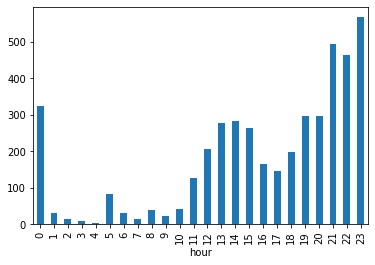

In [20]:
df[df['user']==me].groupby(['hour']).size().sort_index().plot(x="hour", kind='bar')

## Q 4) 
## What is the difference in Weekend vs Weekday usage pattern?
## How many words do I type on average on weekday vs weekend?

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.weekday.html

In [21]:
df['weekday'] = df['date_time'].apply(lambda x: x.day_name()) # can use day_name or weekday from datetime 

In [22]:
df['is_weekend'] = df.weekday.isin(['Sunday', 'Saturday'])

In [24]:
msgs_per_user = df['user'].value_counts(sort=True)
msgs_per_user

Sandesh..!!          9257
Sri Hari Colle       9138
Venkat               5259
Nikil DB             4977
Prajwal Prashanth    4383
Billa                1762
Ktg                  1436
manish lakshman      1297
Abhishek Dharani      587
Kushal Ramakanth      342
Prajwal Kaaadi        191
Kranti Jio            182
Srinidhi Nie          103
Keshava                94
+91 98863 53469        90
Name: user, dtype: int64

In [25]:
top5_users = msgs_per_user.index.tolist()[:5]
top5_users

['Sandesh..!!', 'Sri Hari Colle', 'Venkat', 'Nikil DB', 'Prajwal Prashanth']

In [26]:
df_top5 = df.copy()
df_top5 = df_top5[df_top5.user.isin(top5_users)]
df_top5.head()

,date_time,user,msg,weekday,is_weekend,hour
0,2018-05-14 21:07:00,Sandesh..!!,Lo,Monday,False,21
1,2018-05-14 21:07:00,Sandesh..!!,Inna srh and re melidhe,Monday,False,21
2,2018-05-14 21:07:00,Sandesh..!!,Loude,Monday,False,21
3,2018-05-14 21:08:00,Sri Hari Colle,Run rate maga key,Monday,False,21
4,2018-05-14 21:08:00,Prajwal Prashanth,90 ge all out madbeku,Monday,False,21


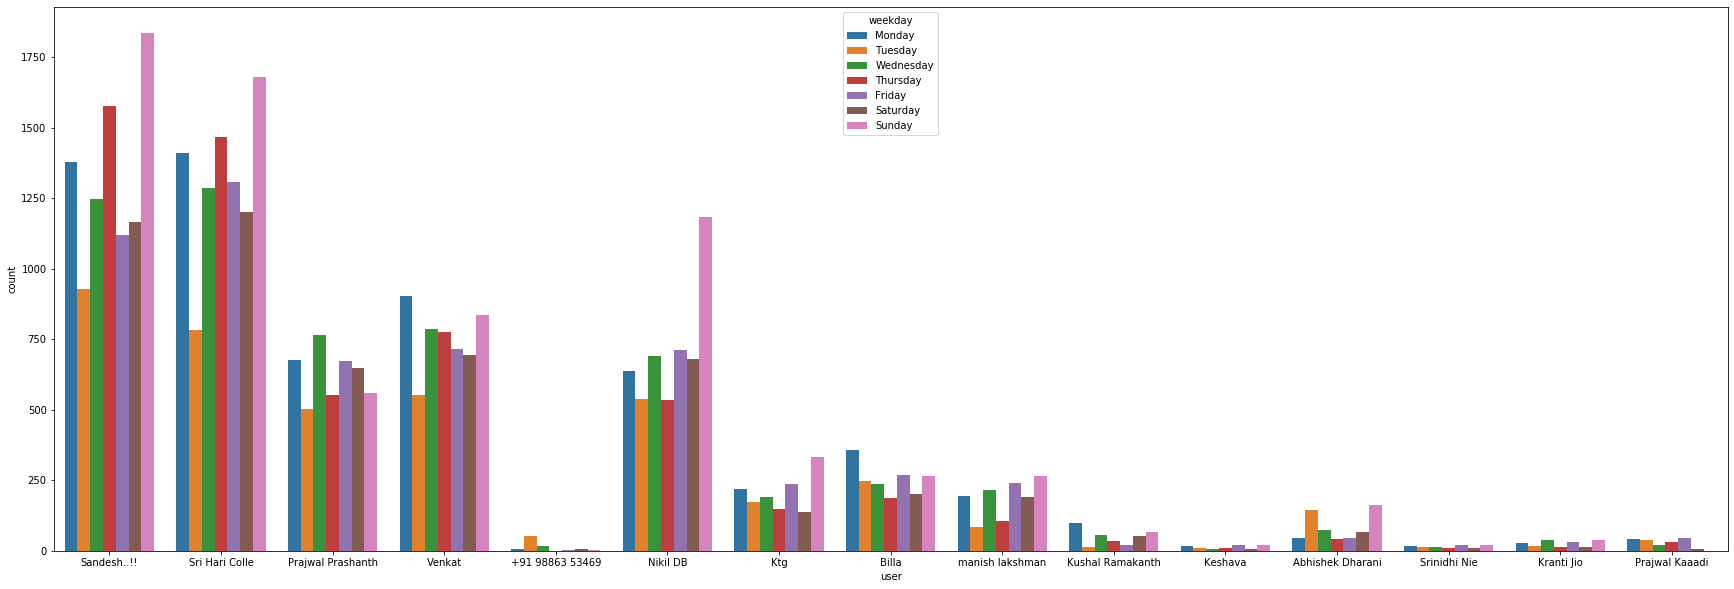

In [27]:
plt.figure(figsize=(30,10))
sns.countplot(x="user", hue="weekday", data=df)

In [28]:
df_top5['is_weekend'] = df_top5.weekday.isin(['Sunday', 'Saturday'])

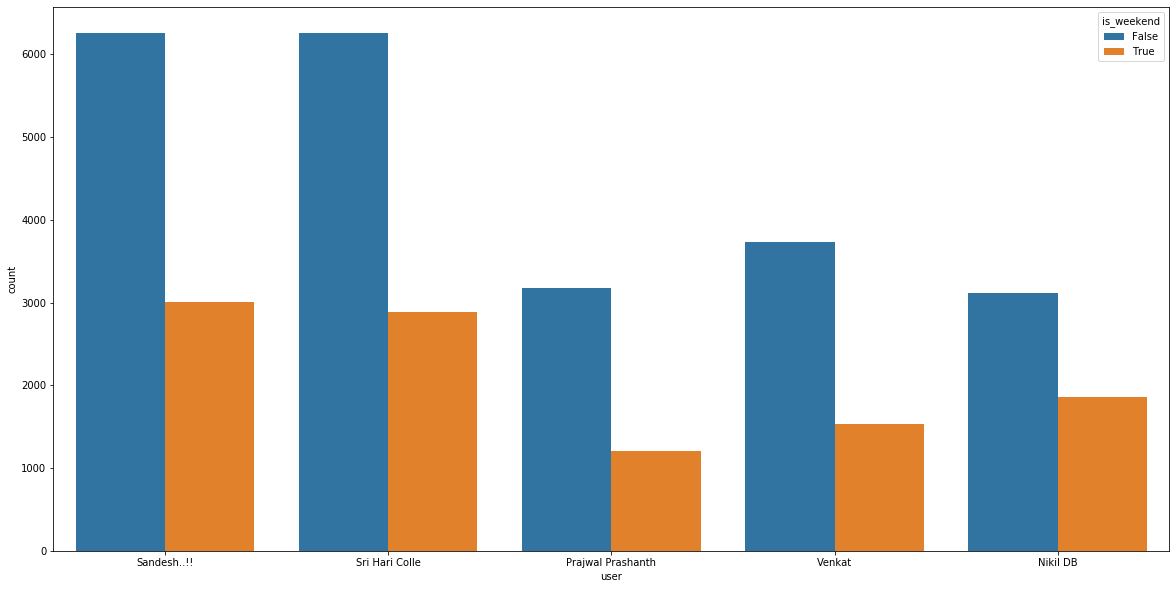

In [29]:
plt.figure(figsize=(20,10))
sns.countplot(x="user", hue="is_weekend", data=df_top5)

In [30]:
def word_count(val):
    return len(val.split())

In [31]:
df['no_of_words'] = df['msg'].apply(word_count)

In [32]:
df_top5['no_of_words'] = df_top5['msg'].apply(word_count)

In [33]:
total_words_weekday = df[df['is_weekend']==False]['no_of_words'].sum()
total_words_weekday

91889

In [34]:
total_words_weekend = df[df['is_weekend']]['no_of_words'].sum()
total_words_weekend

41129

In [35]:
total_words_weekday/5 # average words on a weekday

18377.8

In [36]:
total_words_weekend/2 # average words on a weekend

20564.5

In [37]:
df.groupby('user')['no_of_words'].sum().sort_values(ascending=False)

user
Sandesh..!!          32234
Sri Hari Colle       27111
Venkat               20728
Prajwal Prashanth    17724
Nikil DB             16901
Billa                 4852
manish lakshman       4203
Ktg                   3701
Abhishek Dharani      2001
Kushal Ramakanth      1331
Prajwal Kaaadi         764
Kranti Jio             516
+91 98863 53469        447
Srinidhi Nie           287
Keshava                218
Name: no_of_words, dtype: int64

In [39]:
(df_top5.groupby('user')['no_of_words'].sum()/df_top5.groupby('user').size()).sort_values(ascending=False)

user
Prajwal Prashanth    4.043806
Venkat               3.941434
Sandesh..!!          3.482122
Nikil DB             3.395821
Sri Hari Colle       2.966842
dtype: float64

In [40]:
wordPerMsg_weekday_vs_weekend = (df_top5.groupby(['user', 'is_weekend'])['no_of_words'].sum()/df_top5.groupby(['user', 'is_weekend']).size())
wordPerMsg_weekday_vs_weekend

user               is_weekend
Nikil DB           False         3.359782
                   True          3.456009
Prajwal Prashanth  False         4.004094
                   True          4.148179
Sandesh..!!        False         3.507355
                   True          3.429570
Sri Hari Colle     False         2.969789
                   True          2.960444
Venkat             False         4.049866
                   True          3.676913
dtype: float64

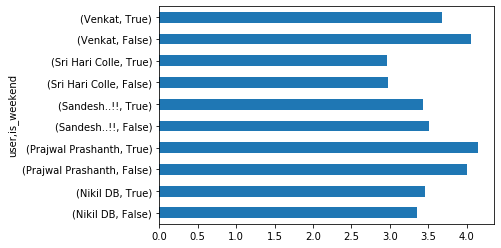

In [41]:
wordPerMsg_weekday_vs_weekend.plot(kind='barh')

## Q 5)
## Most Usage - Time of Day

In [45]:
x = df.groupby(['hour', 'weekday'])['msg'].size().reset_index()
x2 = x.pivot("hour", 'weekday', 'msg')
x2.head()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hour,,,,,,,
0,494.0,578.0,367.0,206.0,650.0,248.0,478.0
1,30.0,188.0,253.0,181.0,9.0,286.0,144.0
2,3.0,124.0,13.0,7.0,8.0,5.0,6.0
3,8.0,5.0,NaN,NaN,1.0,1.0,1.0
4,1.0,2.0,NaN,5.0,1.0,2.0,1.0


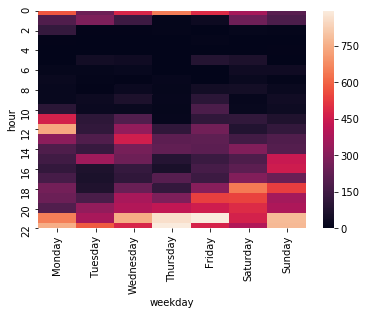

In [46]:
days = ["Monday", 'Tuesday', "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.heatmap(x2[days].fillna(0), robust=True)

## Q 6)
## In any group, do I have any inclination towards responding to someone? 

In [47]:
my_msgs_index = np.array(df[df['user']==me].index)
print(my_msgs_index, my_msgs_index.shape)

[    4     5    11 ... 39073 39076 39077] (4383,)


In [50]:
prev_msgs_index = my_msgs_index - 1
print(prev_msgs_index, prev_msgs_index.shape)

[    3     4    10 ... 39072 39075 39076] (4383,)


In [51]:
df_replies = df.iloc[prev_msgs_index].copy()
df_replies.shape

(4383, 7)

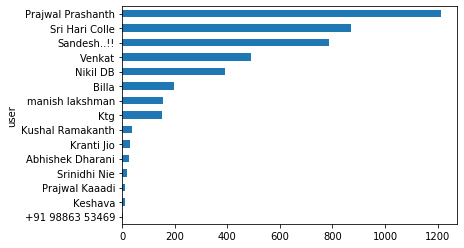

In [52]:
df_replies.groupby(["user"])["msg"].size().sort_values().plot(kind='barh')

## Q 7)
## Which are the most common words?

In [58]:
comment_words = ' '
stopwords = STOPWORDS.update(['lo', 'ge', 'Lo', 'illa', 'yea', 'ella', 'en', 'na', 'En', 'yeah', 'alli', 'ide', 'okay', 'ok', 'will'])
  
for val in df.msg.values: 
    val = str(val) 
    tokens = val.split() 
        
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 


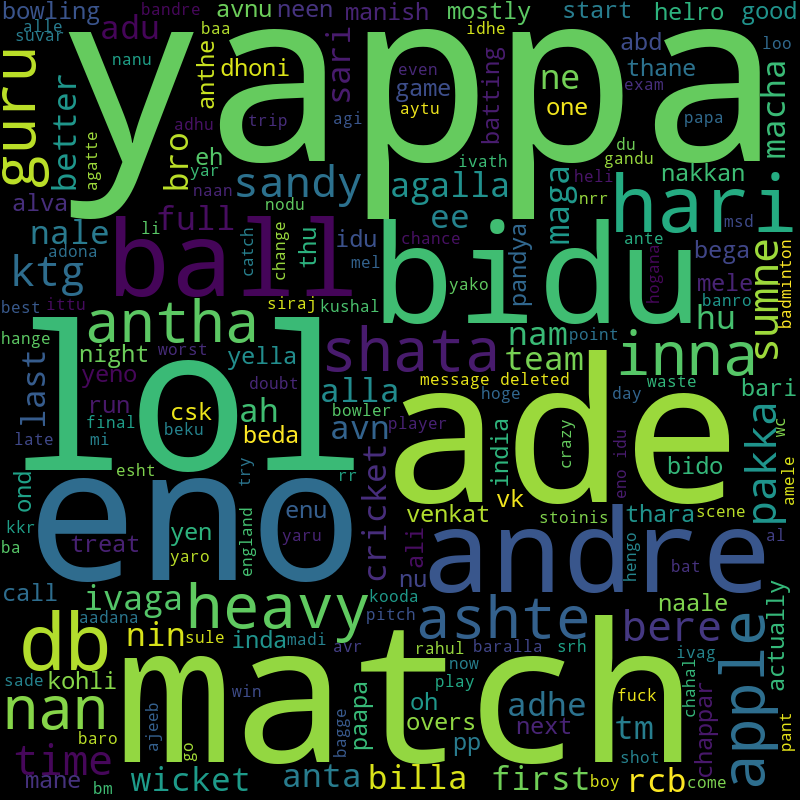

In [59]:
wordcloud.to_image()

## Know What They Know(atleast by little
* Let this meetup series encourage people to work on their own data:
    * Ask many questions on whatsapp chat data, commit to jovian with your answers/analysis visulization. Experiment!!!
* Explore more data resources here's a list i could find, share if you find any @ dsnet.org
    * WhatsApp
    * Google take out (https://takeout.google.com/)
        * Keyboard
        * Maps
        * Calendar 
        * Chrome
        * Pay
        * etc....
    * https://www.cnet.com/how-to/how-to-download-all-your-instagram-data/
    * https://in.pcmag.com/software/120204/how-to-download-your-facebook-data-and-6-surprising-things-i-found
* Lets move step by step EDA first to try answer the questions on our own then move to some ML/DL Models 

## Assingment-kind
* 1way ya 2way, check for a response time between two people

In [ ]:
jovian.commit(notebook_id='PrajwalPrashanth/kwtk-whatsapp-refrence')

[jovian] Saving notebook..


<IPython.core.display.Javascript object>